In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xarray as xr                                                                  
import numpy as np                                                                   
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys                                                                           
import os                                                                            
import glob                                                                          
from IPython.display import HTML
sys.path.append('../')
from shallowpy_plotting import arrange_axes, shade

## Initialize the model

In [3]:
# Initialize default parameters                                                      
# -----------------------------                                                      
exec(open('../shallowpy_defaults.py').read()) 

In [4]:
# Modify default parameters
# -------------------------
run = 'geostrophic_adjustment'
path_data = f'/Users/nbruegge/work/movies/shallow_py/{run}/'

fac = 1
nx = 100*fac
ny = 100*fac
nt = 750

picture_frequency = 0
output_frequency = 25
diagnostic_frequency = output_frequency

dx = 10e3
dy = dx

grav = 9.81
rho = np.array([1024.])
nz = rho.size

H0 = 10.
cph = np.sqrt(grav*H0)
dist = dt*nt * cph
dt  = 0.1*dx/np.sqrt(grav*H0)

nspx = 1
nspy = 1
epsab = 0.01

kh = 1000.
Ah = kh

f0 = 1e-4
beta = 0.*1e-11

do_momentum_advection = False
do_momentum_diffusion = False
do_momentum_coriolis_exp = False
do_momentum_coriolis_imp = True
do_momentum_pressure_gradient = True
do_height_diffusion = False

In [5]:
# Initialize the grid and initial conditions
# ------------------------------------------
exec(open('../shallowpy_grid_setup.py').read())

In [6]:
# Modify initial conditions
# -------------------------
eta0[0,:,:] = 0.1*np.exp(-((Xt-0.5*Lx)**2+(Yt-0.5*Ly)**2)/(1.e-3*(Lx**2+Ly**2)))
eta0[1,:,:] = -H0
ho0 = eta0[:-1,:,:]-eta0[1:,:,:]

ix = np.array([nx//2])
iy = np.array([ny//2])

## Run the model

In [7]:
# Run the model
# -------------
exec(open('../shallowpy_main.py').read())

ll =    725/   750, Total run time: 0.09min, done at 2022-08-25 17:09:50.541412, ho.sum = 1.0e+05, ke.sum = 7.5e-02, cflu = 1.5e-04, cflv = 1.5e-04
--- All done! ---
Total run time: 0.09min, done at 2022-08-25 17:09:50.532160
------


## Post-process the result

In [8]:
# Do post-processing
# ------------------
exec(open('../pp_main.py').read())

In [9]:
%%time
# Combine all netcdf files
# ------------------------
#if output_frequency>0:
if True:
    mfdset_kwargs = dict(combine='nested', concat_dim='time',
        data_vars='minimal', coords='minimal', compat='override', join='override',
        parallel=True
    )
    flist = glob.glob(f'{path_data}/{file_prfx}_????.nc')
    flist.sort()
    ds = xr.open_mfdataset(f'{path_data}/{file_prfx}_????.nc', **mfdset_kwargs)
    fpath = f'{path_data}/{file_prfx}_combined.nc'
    print(f'Save file {fpath}')
    ds['ho'] = ds.ho.where(masktp==1)
    ds['uo'] = ds.uo.where(maskup==1)
    ds['vo'] = ds.vo.where(maskvp==1)
    ds.to_netcdf(fpath)

Save file /Users/nbruegge/work/movies/shallow_py/geostrophic_adjustment//test_combined.nc
CPU times: user 778 ms, sys: 302 ms, total: 1.08 s
Wall time: 810 ms


In [10]:
# from dask.diagnostics import ProgressBar
# with ProgressBar():
#     ds.to_netcdf(fpath)

## Plot overview

In [11]:
nps = ds.time.size
nps

30

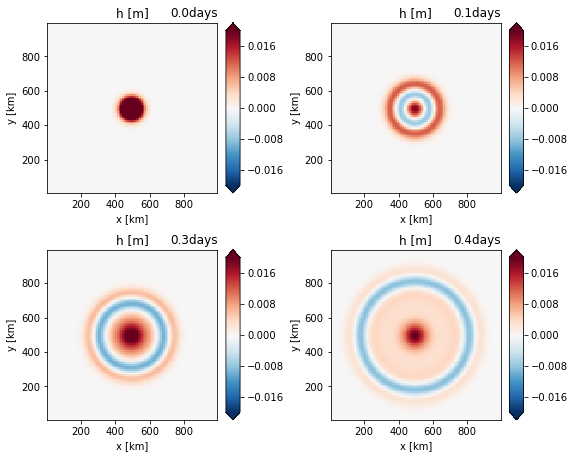

In [12]:
# prepare the animation
var = 'ho'
iz = 0
steps = [1, 5, 9, 14]

hca, hcb = arrange_axes(2,2, plot_cb=True, asp=1., fig_size_fac=1.5, axlab_kw=None, 
                        sharex=False, sharey=False, xlabel='x [km]', ylabel='y [km]')
ii=-1

for nn, ll in enumerate(steps):
    ii+=1; ax=hca[ii]; cax=hcb[ii]
    data = ds['ho'][ll,iz,:,:].compute()
    clim = 2e-2
    hm = shade(ds.xt/1e3, ds.yt/1e3, data-H0, ax=ax, cax=cax, clim=clim)
    ax.set_title('h [m]')
    ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')

## Make an animation

In [19]:
path_fig = f'{path_data}/'
fname_prf = run
fpath = f'{path_data}/test_combined.nc'

mfdset_kwargs = dict(combine='nested', concat_dim='time',
                     data_vars='minimal', coords='minimal', compat='override', join='override',
                    )
ds = xr.open_mfdataset(fpath, **mfdset_kwargs)
#ds = ds.compute()

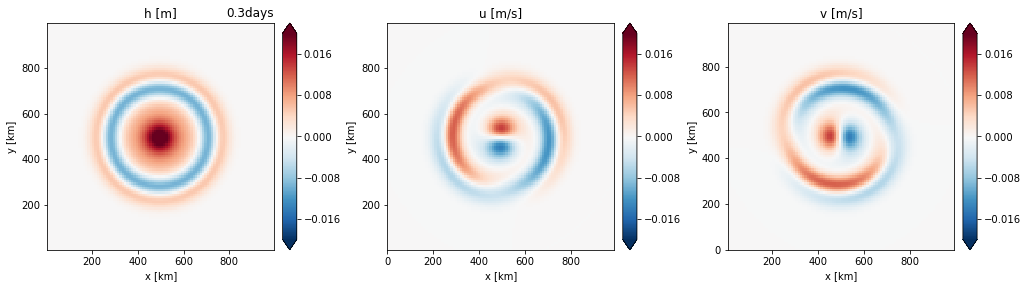

In [20]:
# prepare the animation

nt = ds.time.size
iz = 0
ll=10

hca, hcb = arrange_axes(3,1, plot_cb=True, asp=1., fig_size_fac=2, axlab_kw=None)
ii=-1
fig = plt.gcf()

ii+=1; ax=hca[ii]; cax=hcb[ii]
data = ds['ho'][ll,iz,:,:].compute()
clim = 2e-2
hm0 = shade(ds.xt/1e3, ds.yt/1e3, data-H0, ax=ax, cax=cax, clim=clim)
ax.set_title('h [m]')
ht = ax.set_title(f'{ds.time[ll].data/86400.:.1f}days', loc='right')

ii+=1; ax=hca[ii]; cax=hcb[ii]
data = ds['uo'][ll,iz,:,:].compute()
clim = 2e-2
hm1 = shade(ds.xu/1e3, ds.yt/1e3, data, ax=ax, cax=cax, clim=clim)
ax.set_title('u [m/s]')

ii+=1; ax=hca[ii]; cax=hcb[ii]
data = ds['vo'][ll,iz,:,:].compute()
clim = 2e-2
hm2 = shade(ds.xt/1e3, ds.yu/1e3, data, ax=ax, cax=cax, clim=clim)
ax.set_title('v [m/s]')

for ax in hca:
    ax.set_xlabel('x [km]')
    ax.set_ylabel('y [km]')

In [21]:
# function for updating the animation
def run(ll):
    print(f'll = {ll} / {ds.time.size}', end='\r')
    data = ds['ho'][ll,iz,:,:].data - H0
    hm0[0].set_array(data.flatten())
    data = ds['uo'][ll,iz,:,:].data
    hm1[0].set_array(data.flatten())
    data = ds['vo'][ll,iz,:,:].data
    hm2[0].set_array(data.flatten())
    ht.set_text(f'{ds.time[ll].data/86400.:.1f}days')

In [22]:
%%time
# --- save the animation
ani = animation.FuncAnimation(fig, run, ds.time.size)
if not os.path.exists(path_fig):
    os.mkdir(path_fig)
fpath_fig = f'{path_fig}/{fname_prf}.mp4'
print(f'Saving {fpath_fig}')
ani.save(fpath_fig, writer='ffmpeg', fps=40)

Saving /Users/nbruegge/work/movies/shallow_py/geostrophic_adjustment///<function run at 0x106044d30>.mp4
CPU times: user 4.29 s, sys: 203 ms, total: 4.49 s
Wall time: 4.65 s


## Showing the animation

In [153]:
%%time
HTML(ani.to_jshtml())

CPU times: user 2.25 s, sys: 70.5 ms, total: 2.32 s
Wall time: 2.32 s
